# IMDB sentiment with Vowpal Wabbit
Attempt to train model with the largest available dataset: [IMDb Largest Review Dataset by Enam Biswas](https://www.kaggle.com/ebiswas/imdb-review-dataset)

My preprocessing of the dataset can be found in [this kernel](https://www.kaggle.com/andrii0yerko/preprocessing-for-vowpal-wabbit-sentiment-analysis)

The model will be linear classifier on bag of words, that can be easily implemented with VW.
The main benefit of VW is that it works out-of-core, that means we don't need to load all the dataset into RAM and build a dictionary for bag of words, that can be to large in case of limited RAM, despite VW reads dataset line by line and create bag of words implicitly using hashing trick.

## Environment preparation

In [1]:
%%capture
!pip install bs4 --quiet
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from zipfile import ZipFile
import os
import re

In [2]:
TEMP = '/kaggle/temp'
try:
    os.mkdir(TEMP)
    print(f'{TEMP} created')
except:
    print(f'{TEMP} already exists')

/kaggle/temp created


In [3]:
%%capture
# install the latest VW version
!git clone --recursive https://github.com/VowpalWabbit/vowpal_wabbit.git $TEMP/vowpal_wabbit
!cd $TEMP/vowpal_wabbit/; make 
!cd $TEMP/vowpal_wabbit/; make install

Unzip and load test and original train data, it will be used for validation

In [4]:
directory = '/kaggle/input/word2vec-nlp-tutorial/'
for file in os.listdir(directory):
    if file.split('.')[-1] != 'zip':
        continue
    with ZipFile(directory+file, 'r') as archive:
        archive.extractall()

val_df = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test_df = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)
val_df.shape, test_df.shape

((25000, 3), (25000, 2))

In [5]:
test_df.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


## Test & validation sets preprocessing
Validation and test sets must be preprocessed in the same way as a training one.

In [6]:
stops = set(stopwords.words("english"))
stemmer = PorterStemmer()

# the same as in preprocessing notebook
def preprocess_review(raw_review):
    # Remove HTML
    review_text = BeautifulSoup(raw_review,).get_text()
    # Remove URLs
    review_text = re.sub("https?:\/\/[\w+.\/]+", " ", review_text)
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    # Remove stop words (and stem others if needed)
    meaningful_words = [stemmer.stem(w) for w in words if not w in stops]
        
    return(" ".join( meaningful_words))

In [7]:
%%time
val_df['review'] = val_df['review'].parallel_apply(preprocess_review)
val_df['sentiment'] = val_df['sentiment'].replace(0, -1)
test_df['review'] = test_df['review'].parallel_apply(preprocess_review)

CPU times: user 4.88 s, sys: 737 ms, total: 5.62 s
Wall time: 1min 34s


Save in the Vowpal Wabbit format

In [8]:
np.savetxt("val.vw", val_df[['sentiment', 'review']], delimiter=' |text ', fmt='%s')  # with labels
np.savetxt('test.vw', '|text ' + test_df['review'], fmt='%s')

Let's respect the rules, and drop test lines from the training data.

The same will be done for the validation set to preserve data leakage

In [9]:
# the real labels of training data are unknown, so lines with both possible labels
# will be used for comparing, which seems much more faster than applying "^-?1" regex
np.savetxt(TEMP+'/test_pattern0', '-1 |text ' + test_df['review'], fmt='%s')
np.savetxt(TEMP+'/test_pattern1', '1 |text ' + test_df['review'], fmt='%s')
!cat $TEMP/test_pattern1 $TEMP/test_pattern1 >$TEMP/test_pattern

In [10]:
%%time
INPUT_PATH = "/kaggle/input/preprocessing-for-vowpal-wabbit-sentiment-analysis/train.vw"
!wc -l $INPUT_PATH
# drop the train lines that appears in the test_pattern
!grep -Fvxf $TEMP/test_pattern $INPUT_PATH >/kaggle/temp/temp.vw
!wc -l $TEMP/temp.vw
!grep -Fvxf val.vw $TEMP/temp.vw >train.vw 
!wc -l train.vw 

4146096 /kaggle/input/preprocessing-for-vowpal-wabbit-sentiment-analysis/train.vw
4134558 /kaggle/temp/temp.vw
4111697 train.vw
CPU times: user 1.36 s, sys: 356 ms, total: 1.72 s
Wall time: 1min 6s


# Vowpal Wabbit
Let's start with SVM model, bigrams and 22 bit hash

In [11]:
%%time
!vw --data=train.vw \
    --ngram=2 \
    --bit_precision=22 \
    --loss_function=hinge \
    --final_regressor=model.vw

[info] Generating 2-grams for all namespaces.
final_regressor = model.vw
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
Enabled reductions: gd, scorer-identity
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000       76
0.980187 0.960374            2            2.0   1.0000   0.0396       24
1.044908 1.109629            4            4.0  -1.0000   0.2754      260
1.046622 1.048337            8            8.0  -1.0000   0.7747      260
0.970998 0.895373           16           16.0   1.0000   0.5636      274
0.887162 0.803327           32           32.0   1.0000   0.0244       30
0.849206 0.811250           64           64.0   1.0000   0.2787      120
0.778667 0.708127          128          128.0  -1.0000   0.1444       30
0.753333 0.728000          25

In [12]:
%%time
# predict
!vw --initial_regressor=model.vw \
    --testonly \
    --data=val.vw \
    --ngram=2 \
    --binary \
    --predictions=pred.txt \
    --raw_predictions=pred_margins.txt

[info] Generating 2-grams for all namespaces.
[info] Generating 2-grams for all namespaces.
only testing
predictions = pred.txt
raw predictions = pred_margins.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = val.vw
num sources = 1
Enabled reductions: gd, scorer-identity, binary
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000  -1.0000      438
0.500000 0.000000            2            2.0   1.0000   1.0000      168
0.250000 0.000000            4            4.0  -1.0000  -1.0000      378
0.125000 0.000000            8            8.0  -1.0000  -1.0000      138
0.125000 0.125000           16           16.0  -1.0000  -1.0000      206
0.062500 0.000000           32           32.0   1.0000   1.0000      130
0.046875 0.031250           64           64.0   1.0000   1.0000      158
0.0859

In [13]:
from sklearn.metrics import classification_report
y_pred = np.loadtxt('pred.txt', dtype='int')
y_true = val_df['sentiment']
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

          -1     0.9619    0.8258    0.8887     12500
           1     0.8474    0.9673    0.9034     12500

    accuracy                         0.8966     25000
   macro avg     0.9047    0.8966    0.8960     25000
weighted avg     0.9047    0.8966    0.8960     25000



In [14]:
from sklearn.metrics import hinge_loss, roc_auc_score
raw = np.loadtxt('pred_margins.txt')
print(f'Hinge loss: {hinge_loss(y_true, raw)}')
print(f'ROC AUC: {roc_auc_score(y_true, raw)}')

Hinge loss: 0.26549692935999997
ROC AUC: 0.9671487808000001


## Hyperparameter tuning
Let's explore how the hash dimension and the ngrams affect the model quality

In [15]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def vw_svm_gridsearch_scores(search_params, additional_params=""):
    '''
    Fits VW SVM model (hinge loss) for each element of search space
    and returns accuracy, f1 and hinge scores of each fit.
    
    search_params: 1d iterable
        list of vw param strings to be tried
        E.g. ["--l2=0.1", "--l2=1", "--l2=10"]
    additional_params: string
        additional parameters that to be applied to each fit
        E.g. "--bit_precision=26 --ngram=2"
    '''
    acc_list, f1_list, loss_list, auc_list = [], [], [], []
    
    for param in tqdm(search_params):
        # yeah, cursed
        # fit
        !vw --data=train.vw \
            $param $additional_params \
            --loss_function=hinge \
            --quiet \
            --final_regressor=model.vw

        # predict
        !vw --initial_regressor=model.vw \
            --testonly \
            $param $additional_params \
            --data=val.vw \
            --binary \
            --quiet \
            --predictions=val.pred \
            --raw_predictions=val_raw.pred

        y_pred = np.loadtxt('val.pred', dtype='int')
        raw = np.loadtxt('val_raw.pred')
        acc_list.append(accuracy_score(y_true, y_pred))
        f1_list.append(f1_score(y_true, y_pred))
        loss_list.append(hinge_loss(y_true, raw))
        auc_list.append(roc_auc_score(y_true, raw))
    return {
        'accuracy': acc_list,
        'f1': f1_list,
        'hinge': loss_list,
        'roc_auc': auc_list
    }

In [16]:
def plot_scores(scores, ticks=None):
    if ticks is None:
        ticks = range(len(scores['roc_auc']))
    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    ax[0].plot(ticks, scores['roc_auc'], "o-")
    ax[0].set_title('AUC')
    ax[1].plot(ticks, scores['f1'], "o-")
    ax[1].set_title('F1');
    ax[2].plot(ticks, scores['hinge'], "o-")
    ax[2].set_title('Hinge');

At first, let's receive some intuition on how do the choosen hyperparameters impact the resulting score.

  0%|          | 0/6 [00:00<?, ?it/s]

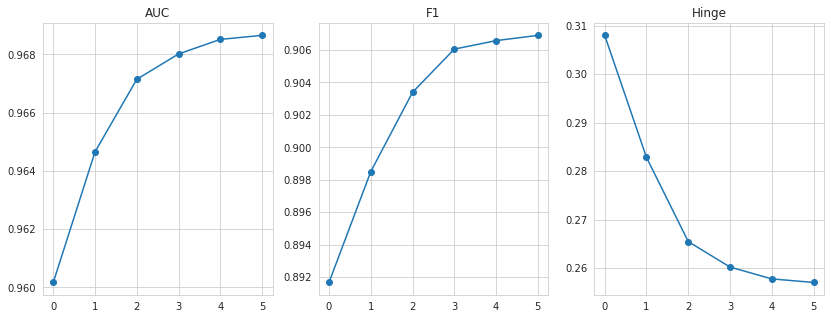

In [17]:
hashdims = [f"--bit_precision={i}" for i in range(18, 30, 2)]
scores = vw_svm_gridsearch_scores(hashdims, "--ngram=2")
plot_scores(scores)

  0%|          | 0/6 [00:00<?, ?it/s]

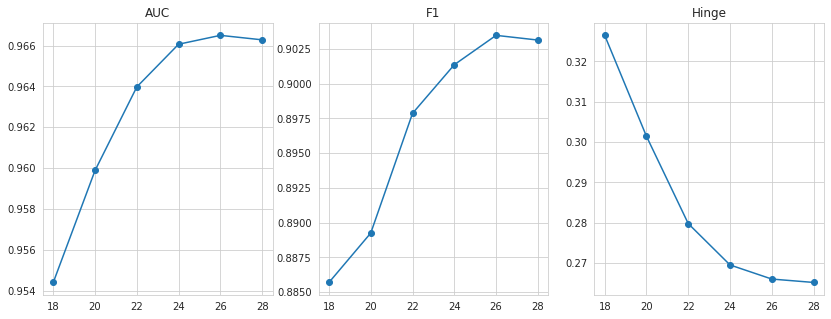

In [18]:
hashdims = [f"--bit_precision={i}" for i in range(18, 30, 2)]
scores = vw_svm_gridsearch_scores(hashdims, "--ngram=2 --ngram=3 --ngram=4")
plot_scores(scores, range(18, 30, 2))

  0%|          | 0/5 [00:00<?, ?it/s]

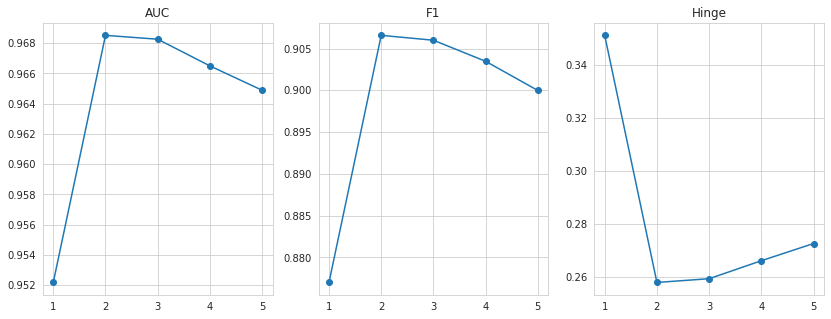

In [19]:
a = [f'--ngram={i}' for i in range(2, 7)]
ngrams = [" ".join(a[:i]) for i in range(len(a)) ]
scores = vw_svm_gridsearch_scores(ngrams, "--bit_precision=26 --binary")
plot_scores(scores, range(1, 6))

Searching for the best hashdim and ngrams combination

  0%|          | 0/12 [00:00<?, ?it/s]

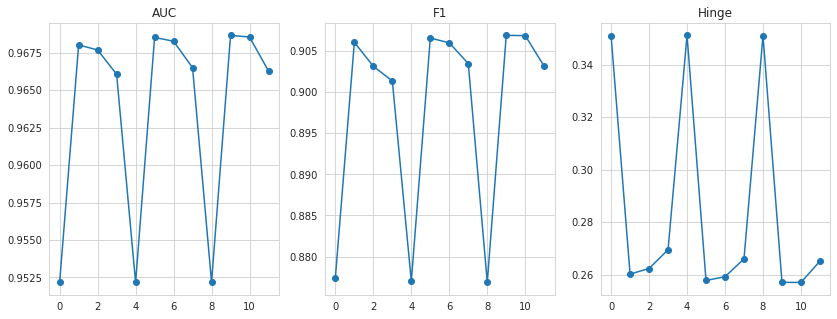

In [20]:
from itertools import product
a = [f'--ngram={i}' for i in range(2, 6)]
ngrams = [" ".join(a[:i]) for i in range(len(a))]
hashdims = [f"--bit_precision={i}" for i in range(24, 30, 2)]
search_space = [" ".join(i) for i in product(hashdims, ngrams)]
scores = vw_svm_gridsearch_scores(search_space, "--binary")
plot_scores(scores)

In [21]:
argmax = np.argmin(scores['hinge']) 
best_params = search_space[argmax]
best_params

'--bit_precision=28 --ngram=2 --ngram=3'

### Regularization
Regularization doesn't help on such sparse data, so I wouldn't try it. If you want to be sure about this yourself, you can run the following code snippet based on `vw-hyperopt.py` (included in vw)

In [22]:
# !python $TEMP/vowpal_wabbit/utl/vw-hyperopt.py \
#     --train=train.vw \
#     --holdout=val.vw \
#     --outer_loss_function=hinge \
#     --vw_space="--l2=1e-8..1e-2~LO --l1=1e-8..1e-2~LO" \
#     --additional_cmd="--binary --bit_precision=28 --ngram=2 --ngram==3 --loss_function=hinge --quiet" \
#     --max_eval=10

In [23]:
# !tail log.log -n 9

# Final model

In [24]:
%%time
!vw --data=train.vw \
     $best_params \
    --loss_function=hinge \
    --final_regressor=model.vw

# predict
!vw --initial_regressor=model.vw \
    --testonly \
    --data=val.vw \
     $best_params \
    --binary \
    --predictions=val.pred \
    --raw_predictions=val_raw.pred

[info] Generating 2-grams for all namespaces.
[info] Generating 3-grams for all namespaces.
final_regressor = model.vw
Num weight bits = 28
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
Enabled reductions: gd, scorer-identity
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000      112
0.986572 0.973144            2            2.0   1.0000   0.0269       34
1.031030 1.075487            4            4.0  -1.0000   0.1898      388
1.033422 1.035814            8            8.0  -1.0000   0.5557      388
0.975030 0.916639           16           16.0   1.0000   0.4306      409
0.904957 0.834884           32           32.0   1.0000   0.0400       43
0.874902 0.844848           64           64.0   1.0000   0.2437      178
0.816743 0.758583          128          128.0  -1.0000  

In [25]:
y_true = val_df['sentiment']
y_pred = np.loadtxt('val.pred', dtype='int')
raw = np.loadtxt('val_raw.pred')
print(classification_report(y_true, y_pred, digits=4))

print(f'Hinge loss: {hinge_loss(y_true, raw)}')
print(f'ROC AUC: {roc_auc_score(y_true, raw)}')

              precision    recall  f1-score   support

          -1     0.9601    0.8366    0.8941     12500
           1     0.8552    0.9652    0.9069     12500

    accuracy                         0.9009     25000
   macro avg     0.9076    0.9009    0.9005     25000
weighted avg     0.9076    0.9009    0.9005     25000

Hinge loss: 0.25704316996000004
ROC AUC: 0.96854664


## Making a submission

In [26]:
!vw --initial_regressor=model.vw \
    --testonly \
    --data=test.vw \
     $best_params \
    --binary \
    --quiet \
    --raw_predictions=test.pred

a = np.loadtxt("test.pred")
test_df['sentiment'] = a
test_df[['id','sentiment']].to_csv("submission.csv", index=False, quoting=3) # 0.97240 accuracy!!

In [27]:
test_df

,id,review,sentiment
0,"""12311_10""",natur film main theme mortal nostalgia loss in...,2.710540
1,"""8348_2""",movi disast within disast film full great acti...,-2.543389
2,"""5828_4""",movi kid saw tonight child love one point kid ...,-0.858935
3,"""7186_2""",afraid dark left impress sever differ screenpl...,-1.081813
4,"""12128_7""",accur depict small time mob life film new jers...,2.272531
...,...,...,...
24995,"""2155_10""",soni pictur classic look soni got right harri ...,1.615181
24996,"""59_10""",alway felt ms merkerson never gotten role fit ...,2.079889
24997,"""2531_1""",disappoint movi familiar case read mark fuhrma...,-1.071386
24998,"""7772_8""",open sequenc fill black white shot reminisc go...,1.858168


In [28]:
!rm *.log
!rm *.pred
!rm *.json
!rm *.cache
!rm *.txt
!rm *.tsv

rm: cannot remove '*.log': No such file or directory
rm: cannot remove '*.json': No such file or directory
rm: cannot remove '*.cache': No such file or directory


# Ways for improvement
- Convergence hyperparameters tuning
- Usually, set log loss as the objective is a good idea when roc auc is a target metric. Should be tried.
- Better preprocessing. What about lemmatization instead of stemming? Maybe we should choose higher and lower rating thresholds for the positive and negative classes than ones used by original dataset creators.